#**Naive RAG**

In a Naive or 2-Step RAG (Retrieval-Augmented Generation) setup, the process follows a simple yet effective pipeline: first, relevant context is retrieved from a pre-indexed knowledge base, and then a language model uses that context to generate an informed answer. The workflow begins by loading and chunking documents, creating embeddings, and storing them in a vector database for semantic search. During inference, a user query is embedded and compared to stored vectors to fetch the most similar chunks (retrieval), which are then passed as contextual input to the LLM to produce a grounded and context-aware response (generation). This structure ensures interpretability, reproducibility, and reduced hallucination in the model outputs.

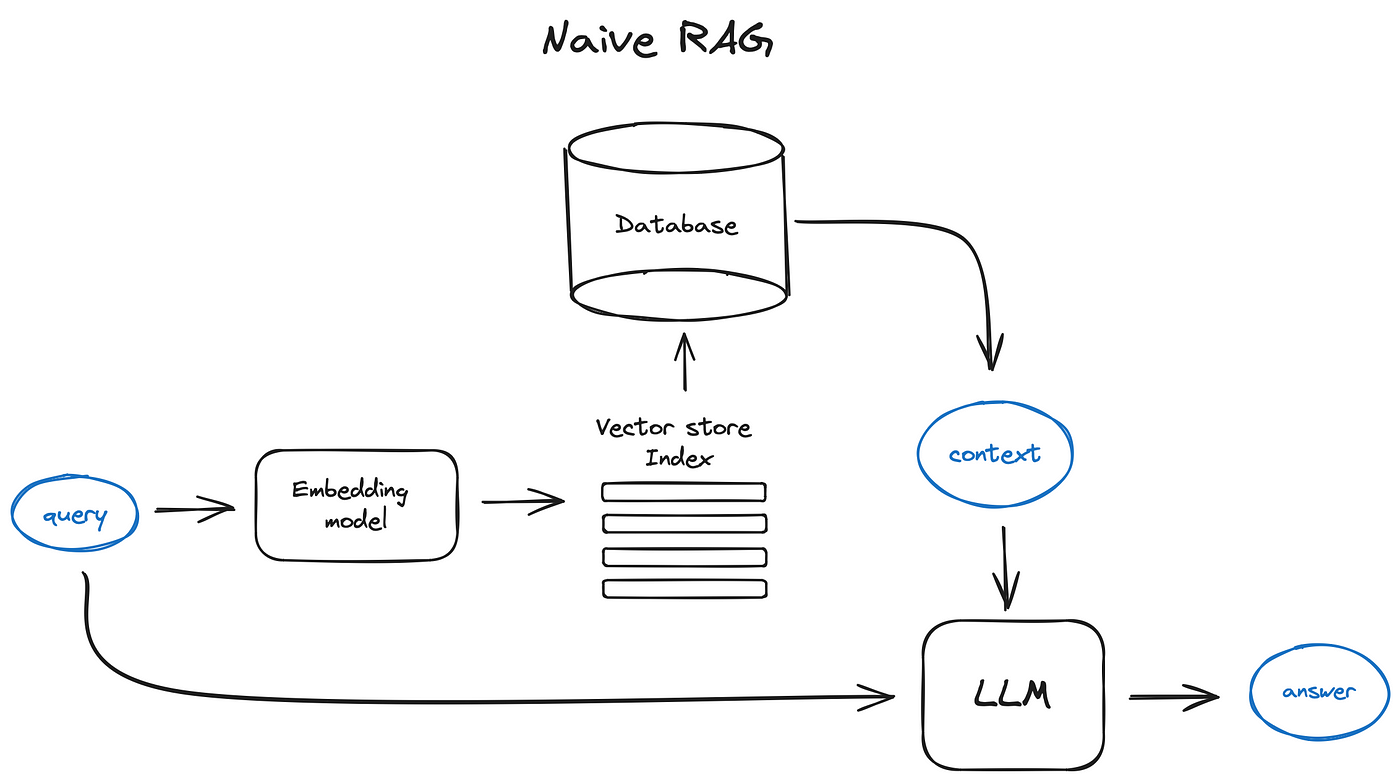

## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture --no-stderr
%pip install -U langchain_groq langchain_community langchain_experimental
!pip install sentence-transformers
!pip install pypdf
!pip install python-dotenv
!pip install -q transformers einops accelerate  bitsandbytes
!pip install langchain-huggingface
!pip install chromadb
!pip install pymupdf

In [10]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from typing import TypedDict, Annotated, List, Literal, Dict
from pydantic import BaseModel, Field
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from huggingface_hub.hf_api import HfFolder
from langchain_core.tools import tool
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import TextLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import PyMuPDFLoader

In [4]:
from groq import Groq
from langchain_groq import ChatGroq
import getpass
import os
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
from langchain_groq import ChatGroq
# LLM
llm = ChatGroq(model="openai/gpt-oss-20b", temperature=0.2)

## Processing the Document


The part where we load the documents, split them to chunks and index these chunks to vectorstore

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader, TextLoader
import chromadb

# Path to the source document (PDF)
file_path = 'PATH TO DOCUMENT'

# --- Step 1: Load the PDF document ---
# Using LangChain's PyMuPDFLoader to extract text from each page.
# The "extract_tables" parameter can also capture tabular data if present.

loader = PyMuPDFLoader(
    file_path=file_path,
    mode="page",
    extract_tables="csv"
)

docs = loader.load()
doc_splits = []

# --- Step 2: Split the document into chunks ---
# Large texts are divided into smaller, semantically coherent chunks.
# RecursiveCharacterTextSplitter uses token-aware splitting (via TikToken encoder)
# to preserve context boundaries while maintaining the chunk size limit.

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=100
)
for doc in docs:
    splits = text_splitter.split_documents([doc])
    doc_splits.extend(splits)

# --- Step 3: Create a persistent vector store using ChromaDB ---
# The vector store allows semantic retrieval based on embedding similarity.
persist_directory = "/content/drive/MyDrive/Colab Notebooks"
persistent_client = chromadb.PersistentClient()

# Collections in ChromaDB group related embeddings and metadata together.
collection = persistent_client.get_or_create_collection("index-name")

# --- Step 4: Generate embeddings for document chunks ---
#  HuggingFace’s multilingual embedding model for cross-lingual support. --> intfloat/multilingual-e5-large
# Normalization ensures consistent cosine similarity results.
embeddings= HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large",multi_process=True,encode_kwargs={"normalize_embeddings": True})

# --- Step 5: Store the chunks and embeddings in ChromaDB ---
vector_store = Chroma.from_documents(
    documents=doc_splits,
    collection_name="index-name",
    embedding= HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large",multi_process=True,encode_kwargs={"normalize_embeddings": True}  # Set `True` for cosine similarity
    ),
    persist_directory=persist_directory,
    client=persistent_client,
)


Consider using the pymupdf_layout package for a greatly improved page layout analysis.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

## Retrieval

This retrieval step corresponds to the “Retrieve” part of the RAG pipeline.
It identifies the top-k relevant text chunks from the vector store that will later be provided as context to the language model.

There are different types of semantic search functions that are shared by Langchain. [Chroma - Docs by Langchain](https://docs.langchain.com/oss/python/integrations/vectorstores/chroma#similarity-search )

In [8]:
# --- Step 6: Retrieve relevant documents based on a query ---
# We use the similarity_search method, which computes cosine similarity between
# the query embedding and the stored chunk embeddings.
# The parameter 'k' defines how many top matches are retrieved.

docs = vector_store.similarity_search(query="What is Ensemble Voting Analysis?", k=10)

In [9]:
# Inspect the retrieved documents (optional)
docs

[Document(metadata={'author': 'Qile Jiang; George Karniadakis', 'format': 'PDF 1.7', 'trapped': '', 'file_path': '/content/drive/MyDrive/Colab Notebooks/2511.07262v1.pdf', 'creationDate': '', 'page': 6, 'producer': 'pikepdf 8.15.1', 'creationdate': '', 'source': '/content/drive/MyDrive/Colab Notebooks/2511.07262v1.pdf', 'total_pages': 45, 'subject': '', 'keywords': '', 'creator': 'arXiv GenPDF (tex2pdf:4177c2c)', 'title': 'AgenticSciML: Collaborative Multi-Agent Systems for Emergent Discovery in Scientific Machine Learning', 'moddate': '', 'modDate': ''}, page_content='Figure 3: Performance improvements achieved by the multi-agent system over single-agent baselines across all\nbenchmark problems. The y-axis shows the improvement factor (root score / champion score) on a logarithmic scale. In\nevery case, the multi-agent system discovers solutions that outperform the single-agent baseline, with improvement\nfactors ranging from 10× to over 11,000×.\n3. Burger’s Equation (A.3.4): Dividin

## Generation


This is the “Generate” step — the model synthesizes an answer using only the retrieved context, preventing hallucination.
It completes the Naive 2-step RAG workflow: Retrieve → Generate.

In [13]:
# --- Step 7: Define the generation prompt ---
# The language model receives both the user's question and retrieved context.
# The prompt enforces grounded responses strictly based on the retrieved context.

generate_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template="""Answer the question based only on the providing context:
                Context: {context}
                Question: {question}
    """
)

In [22]:
# Alternatively, for a chat-style model:
generate_prompt = ChatPromptTemplate([    ("system","""Answer the question based only on the provided context."""),
    ("human","""Question: {question}\nContext: {context}""")
    ])

In [26]:
# --- Step 8: Invoke the LLM with the prompt and context ---
question = "What is Ensemble Voting Analysis?"
chain = generate_prompt | llm | StrOutputParser()
response = chain.invoke({"question": question, "context": docs})

In [24]:
response

'**Ensemble Voting Analysis** is the part of the paper that examines how the multi‑agent system’s *selector ensemble*—Gemini‑2.5‑pro, GPT‑5‑mini, and Grok‑4‑fast—consensus‑builds the next set of solutions to mutate.\n\n* **What it does**  \n  * Each selector independently nominates three candidate solutions from the current solution tree.  \n  * The three nominations are then compared across the three selectors.  \n  * The authors plot the voting agreement (Figure\u202f4) for the top‑three choices in every experiment.\n\n* **Key observations**  \n  * The first choice is almost always agreed upon, indicating that all selectors see the same high‑performing solution.  \n  * The second choice is also largely agreed upon, again reflecting a shared view of the next best candidate.  \n  * The third choice shows the most disagreement, because it is deliberately an exploratory pick—different selectors think different “potential‑for‑improvement” solutions are worth trying.\n\n* **Why it matters*